In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- BAGIAN 1: DATA PREPARATION (Copy dari Notebook 02) ---
# Kita perlu load ulang datanya agar variabelnya ada di memory notebook ini

# 1. Load Data
df = pd.read_csv('../data/BBRI_raw.csv', header=[0, 1, 2], index_col=0, parse_dates=True)
df.columns = df.columns.get_level_values(0)
df = df.dropna()
data = df.filter(['Close']).values

# 2. Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Sliding Window
window_size = 60
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# 4. Convert to Tensor
X_tensor = torch.from_numpy(X).type(torch.Tensor).unsqueeze(-1)
y_tensor = torch.from_numpy(y).type(torch.Tensor).unsqueeze(-1)

# --- BAGIAN 2: SPLIT & DATALOADER ---

# Bagi data jadi 80% Training, 20% Testing
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# Bungkus ke DataLoader (Biar AI belajarnya nyicil per batch 32 data)
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

print("Data Siap!")
print(f"Total Data Train: {len(X_train)} sampel")
print(f"Total Data Test: {len(X_test)} sampel")

Data Siap!
Total Data Train: 1317 sampel
Total Data Test: 330 sampel


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Arsitektur LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully Connected Layer untuk mengubah output LSTM menjadi prediksi harga
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Inisialisasi hidden state dan cell state dengan nol
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Kita hanya ambil output dari time step terakhir
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel()
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 20
model.train()

for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        # 1. Forward pass: Tebak harga
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # 2. Backward pass: Hitung gradien (Backprop!)
        optimizer.zero_grad() # Reset gradien lama
        loss.backward()       # Kalkulus Chain Rule terjadi di sini
        
        # 3. Update weights: Melangkah ke bawah (Descent)
        optimizer.step()
        
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

Epoch [5/20], Loss: 0.001076
Epoch [10/20], Loss: 0.001102
Epoch [15/20], Loss: 0.000222
Epoch [20/20], Loss: 0.000895


=== HASIL EVALUASI ===
Final Training Loss : 0.000895
Test Loss (MSE)     : 0.000948
Test RMSE           : 0.030786


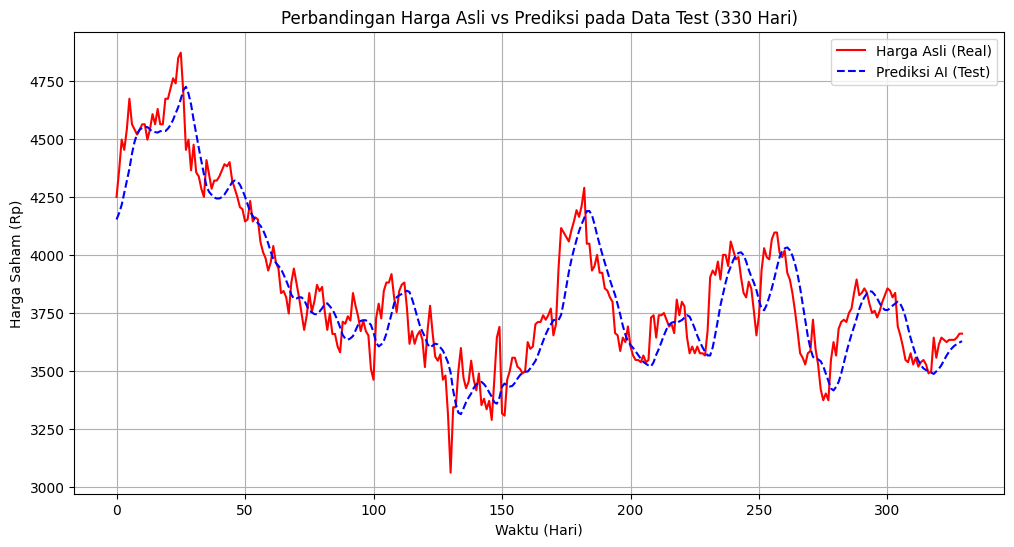

In [13]:
# ==========================================
# EVALUASI MODEL PADA DATA TEST (UNSEEN DATA)
# ==========================================
import matplotlib.pyplot as plt

# Matikan mode gradient karena kita hanya mau tes (Hemat memori)
model.eval()
with torch.no_grad():
    # Model menebak data test (330 sampel)
    test_outputs = model(X_test)
    
    # Hitung Error (MSE & RMSE)
    test_loss = criterion(test_outputs, y_test)
    rmse = torch.sqrt(test_loss)
    
    print("=== HASIL EVALUASI ===")
    print(f"Final Training Loss : {loss.item():.6f}")
    print(f"Test Loss (MSE)     : {test_loss.item():.6f}")
    print(f"Test RMSE           : {rmse.item():.6f}")

# --- VISUALISASI HASIL PREDIKSI (TEST SET) ---
# Kembalikan ke angka Rupiah asli (Inverse Transform)
predicted_prices = scaler.inverse_transform(test_outputs.numpy())
actual_prices = scaler.inverse_transform(y_test.numpy())

# Plotting
plt.figure(figsize=(12,6))
plt.plot(actual_prices, color='red', label='Harga Asli (Real)')
plt.plot(predicted_prices, color='blue', linestyle='dashed', label='Prediksi AI (Test)')
plt.title('Perbandingan Harga Asli vs Prediksi pada Data Test (330 Hari)')
plt.xlabel('Waktu (Hari)')
plt.ylabel('Harga Saham (Rp)')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
torch.save(model.state_dict(), '../models/lstm_stock_model.pth')
print("Model berhasil disimpan ke dalam folder 'models'")

Model berhasil disimpan ke dalam folder 'models'


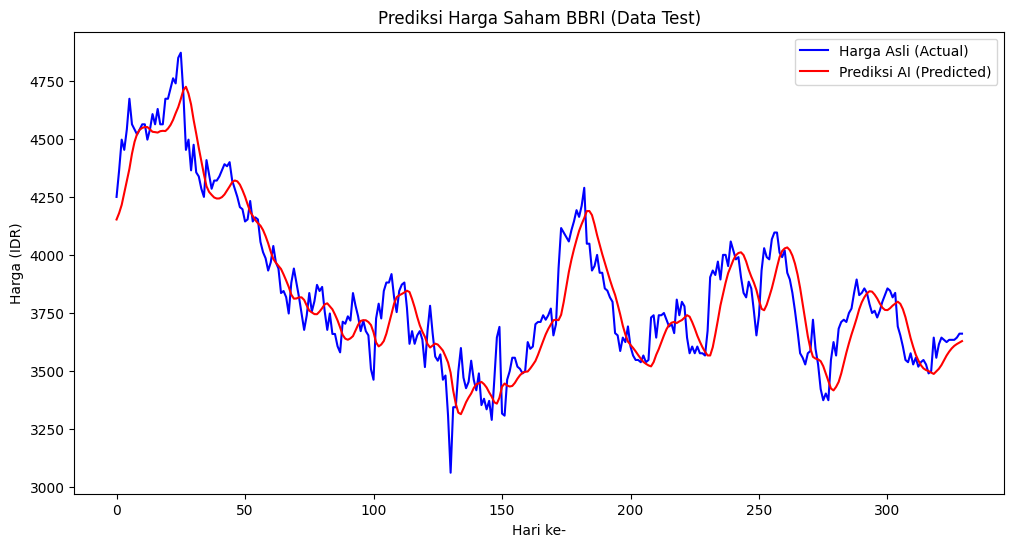

In [15]:
import matplotlib.pyplot as plt

model.eval() # Set mode ke evaluasi (matikan dropout/training specific features)

with torch.no_grad(): # Matikan gradien (hemat memori karena gak perlu backprop)
    # Prediksi data test
    test_predictions = model(X_test).cpu().numpy()
    
    # Kembalikan angka 0-1 menjadi harga Rupiah asli
    test_predictions = scaler.inverse_transform(test_predictions)
    actual_prices = scaler.inverse_transform(y_test.cpu().numpy())

# Plotting
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Harga Asli (Actual)', color='blue')
plt.plot(test_predictions, label='Prediksi AI (Predicted)', color='red')
plt.title('Prediksi Harga Saham BBRI (Data Test)')
plt.xlabel('Hari ke-')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.show()